# <Hsuan-You (Shaun) Lin / hl116 / **HW6**>

## Problem 1: StyleGAN (7 points)

In this problem, you will use [StyleGAN2](https://arxiv.org/abs/1912.04958) for controlled image generation. Make sure to run the first 3 code cells of the provided Colab notebook. The first cell installs StyleGAN2 and its dependencies. The second cell loads a pre-trained StyleGAN2 model for faces. The third cell provides you with some useful utility functions. Some preliminary code on how to generate synthetic faces using the utility functions is also provided in cell 4.

StyleGAN2’s generator converts a vector **𝑧 ∈ 𝑅^512** drawn from the standard Normal distribution into a ‘style’ vector **𝑤 ∈ 𝑅^512** . The generator then processes the style vector to produce an image **𝐼 ∈ 𝑅^1024×1024×3**. In this problem, you will find a direction in the style space corresponding to perceived gender and use that direction to alter the perceived gender of synthetic faces.

In [ ]:
# setup correct PyTorch version
!pip install -U torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
import torch 

# Download the code
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

# install other dependencies 
!pip install ninja

print('PyTorch version: {}'.format(torch.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(torch.cuda.get_device_name()))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2)
ERROR: No matching distribution found for torch==1.7.1+cu110
Cloning into 'stylegan2-ada-pytor

In [ ]:
# Download the model
import argparse
import numpy as np
import PIL.Image
import dnnlib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import matplotlib.pyplot as plt
import legacy
import cv2
import torch
from tqdm.autonotebook import tqdm

device = torch.device('cuda')

# Choose between these pretrained models
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqdog.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqwild.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/brecahad.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

# If downloads fails, you can try downloading manually and uploading to the session directly 
# network_pkl = "/content/ffhq.pkl"

print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as f:
  G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...

<ipython-input-2-97737518342e>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


 done


In [ ]:
# Useful utility functions...

# Generates an image from a style vector.
def generate_image_from_style(dlatent, noise_mode='none'):

  if len(dlatent.shape) == 1: 
    dlatent = dlatent.unsqueeze(0)
    
  row_images = G.synthesis(dlatent, noise_mode=noise_mode)
  row_images = (row_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return row_images[0].cpu().numpy()    

# Converts a noise vector z to a style vector w.
def convert_z_to_w(latent, truncation_psi=0.7, truncation_cutoff=9, class_idx=None):
  label = torch.zeros([1, G.c_dim], device=device)   
  if G.c_dim != 0:
    if class_idx is None:
      RuntimeError('Must specify class label with class_idx when using a conditional network')
    label[:, class_idx] = 1
  else:
    if class_idx is not None:
      print(f'warning: class_idx={class_idx} ignored when running on an unconditional network')
  return G.mapping(latent, label, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


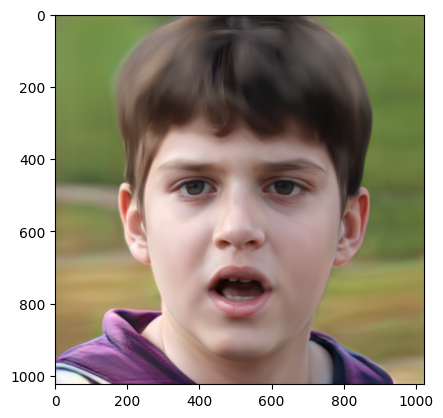

In [ ]:
# Sample code to generate images.
np.random.seed(123) # You can change this random seed.

# Generate a random noise (z) vector. 
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

# Convert z vector to w vector.
w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img = generate_image_from_style(w)
plt.imshow(img)

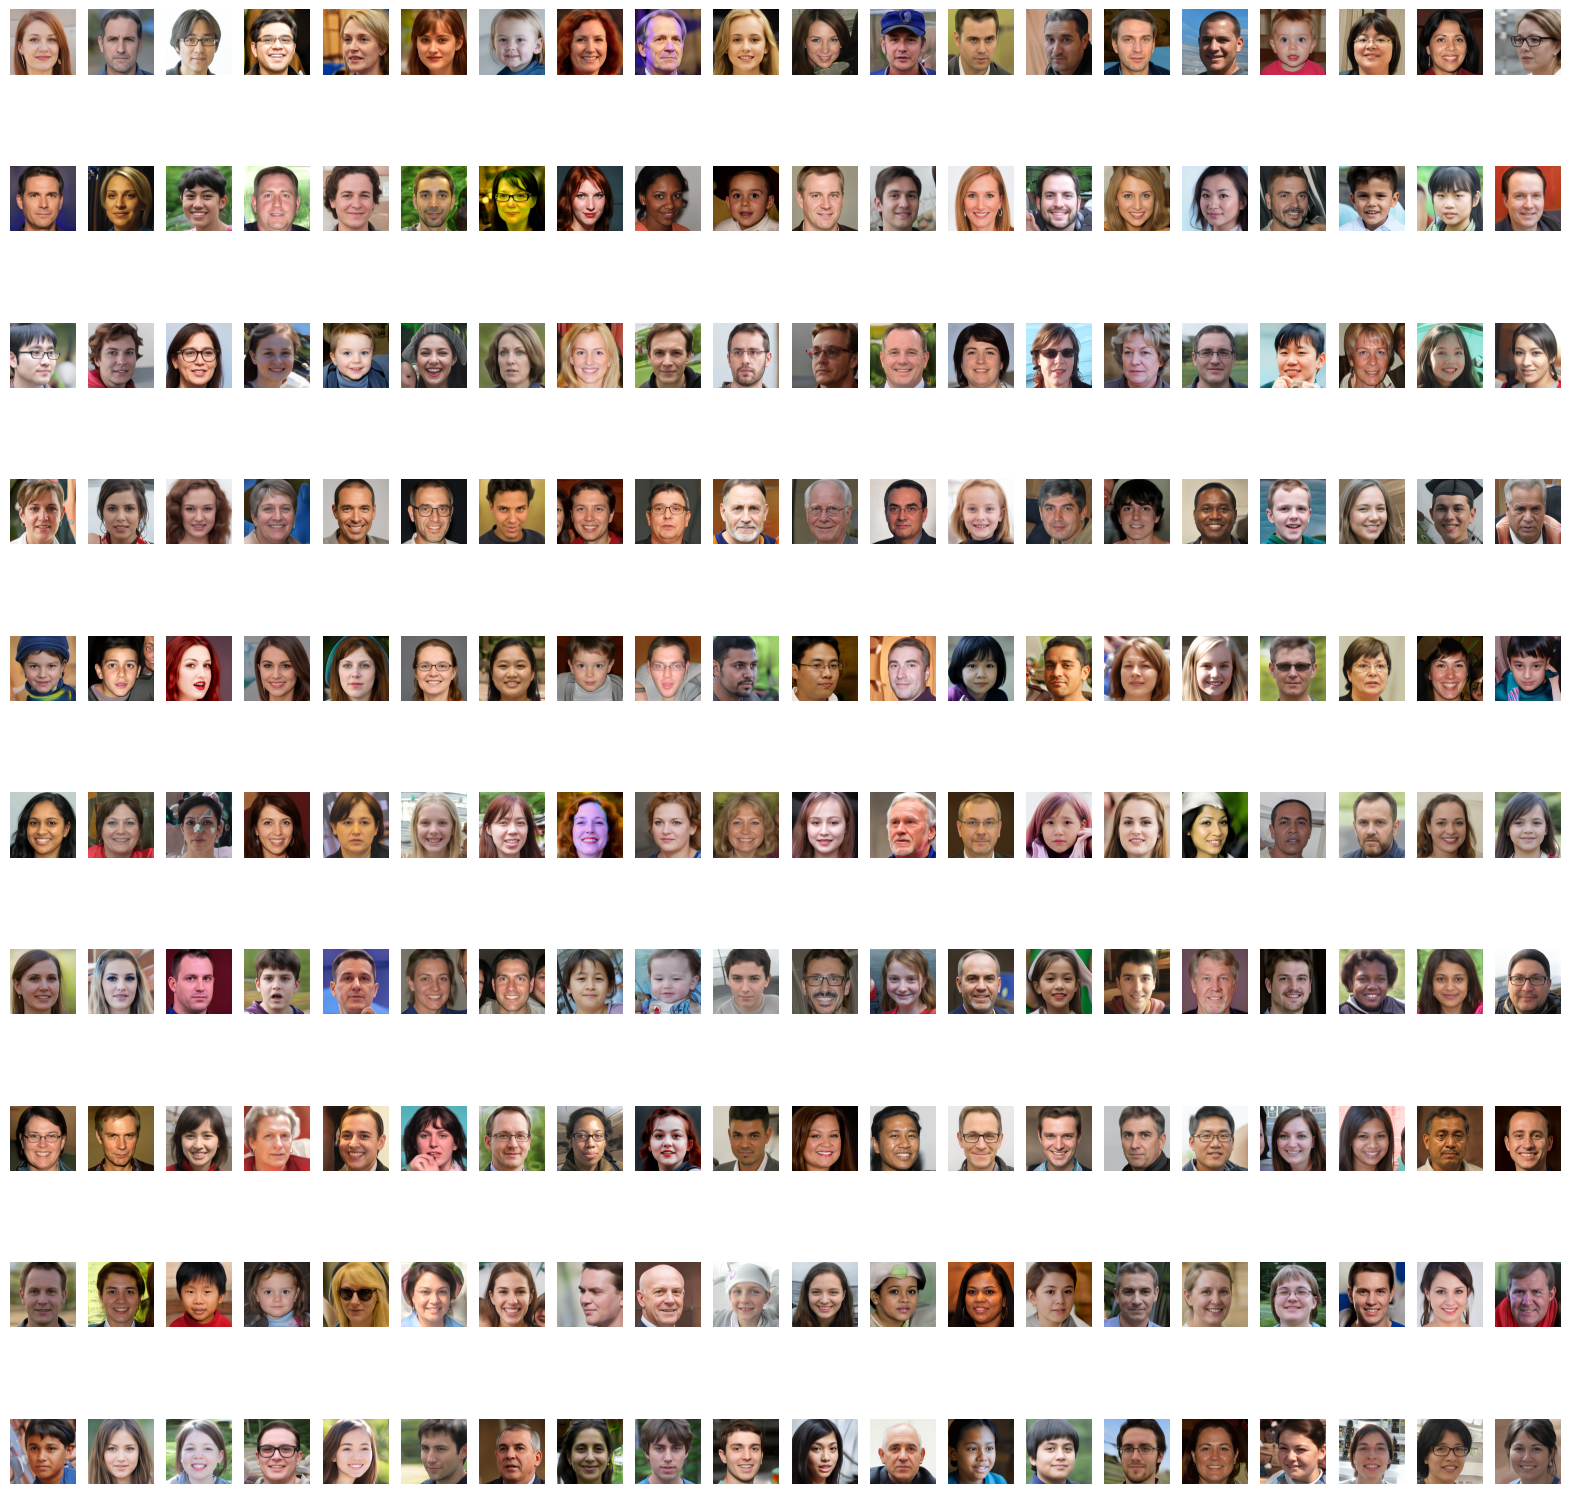

In [ ]:
# Sample code to generate images for 200 different random seeds.
num_images = 200

fig, axs = plt.subplots(10, 20, figsize=(20, 20))
axs = axs.flatten()
for i in range(num_images):
    # Generate a random noise (z) vector for this iteration.
    np.random.seed(i)
    z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

    # Convert z vector to w vector.
    w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)

    # Generate and show image.
    img = generate_image_from_style(w)
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()

In [ ]:
# download 
!gdown "1NcRdVWicD1pS1X_XN3MfBrXQwffhB3wF" -O "../"

Downloading...
From: https://drive.google.com/uc?id=1NcRdVWicD1pS1X_XN3MfBrXQwffhB3wF
To: /content/ffhq-gender,age,pitch,roll,yaw.weights
100% 94.4M/94.4M [00:00<00:00, 108MB/s]


In [ ]:
from torchvision import models as tv
cnn = tv.resnet50(pretrained=False, progress=True, num_classes = 5)
cnn.eval()
cnn.load_state_dict(torch.load('../ffhq-gender,age,pitch,roll,yaw.weights', map_location=lambda storage, loc: storage))

# Returns whether face is perceptually female (True) or male (False) given
# an input image of shape (H, W, 3).
def face_is_female(img):
  im = np.asarray(img)/255.0
  im = cv2.resize(im, (256, 256))
  im = np.expand_dims(np.transpose(im, (2,0,1)), 0)
  im = torch.FloatTensor(im)
  logits = cnn(im)[0, 0]
  return (logits < 0.5).numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### a.

Interpolating between images: Choose two random noise vectors **z0**, and **z1**, such that the two generated faces have different perceived genders based on the **face_is_female** function1. This function uses a pre-trained face gender classifier to make its prediction.

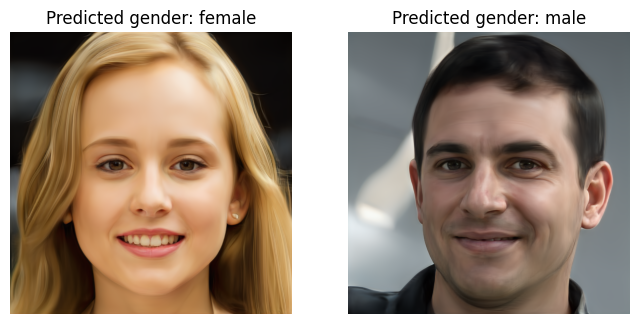

In [ ]:
# Set random seed.
np.random.seed(9)

# Generate two random noise vectors.
z0 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
z1 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

# Convert noise vectors to w vectors.
w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)
w1 = convert_z_to_w(z1, truncation_psi=0.7, truncation_cutoff=9)

# Generate images from w vectors.
img0 = generate_image_from_style(w0)
img1 = generate_image_from_style(w1)

# Show images.
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img0)
ax[0].axis(False)
ax[0].set_title('Predicted gender: {}'.format('female' if face_is_female(img0) else 'male'))
ax[1].imshow(img1)
ax[1].axis(False)
ax[1].set_title('Predicted gender: {}'.format('female' if face_is_female(img1) else 'male'))
plt.show()

i. Interpolate between the **latent vectors** **z0**, and **z1** with 5 intermediate points. Show a strip of 7 faces along with the classifier predictions in your report.

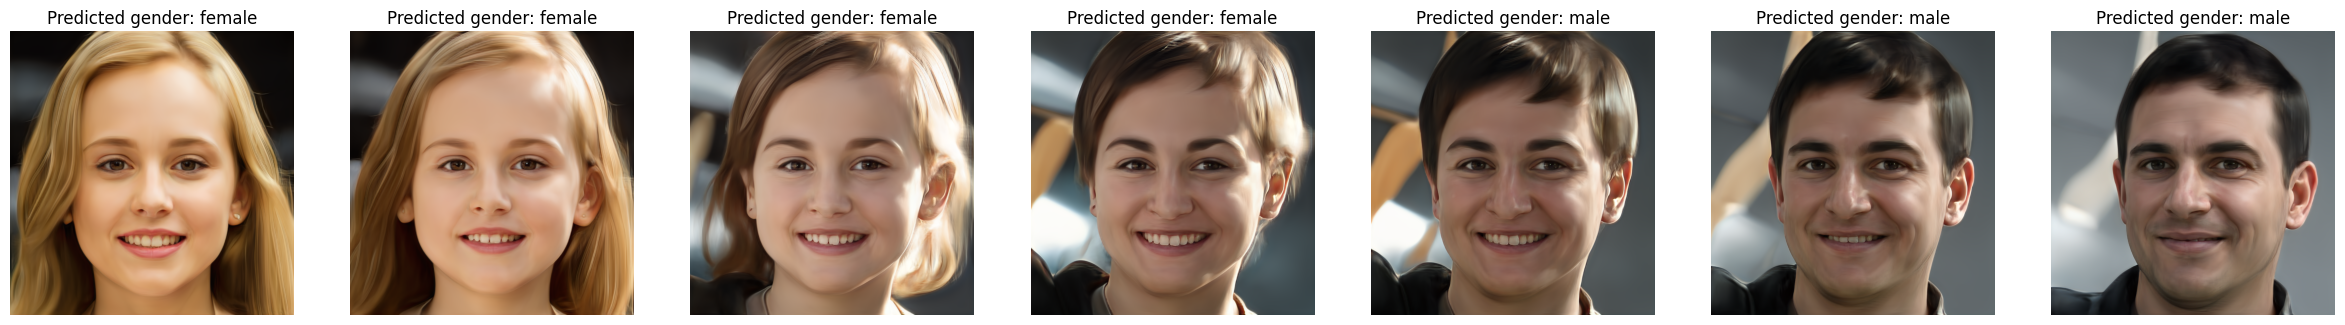

In [ ]:
# Interpolate between the latent vectors.
interval = (z1 - z0) / 6

fig, bx = plt.subplots(1, 7, figsize = (30, 10))
for i, _ in enumerate(range(6)):
  # Display the first image and its predicted gender.
  bx[0].imshow(img0)
  bx[0].axis(False)
  bx[0].set_title('Predicted gender: {}'.format('female' if face_is_female(img0) else 'male'))

  zs = z0 + (i + 1) * interval

  # Convert the latent vector to a style vector and generate the image.
  ws = convert_z_to_w(zs, truncation_psi=0.7, truncation_cutoff=9)
  img = generate_image_from_style(ws)
  is_female = face_is_female(img)

  # Display all images and its predicted gender.
  bx[i+1].imshow(img)
  bx[i+1].axis(False)
  bx[i+1].set_title('Predicted gender: {}'.format('female' if is_female else 'male'))

plt.show()

ii. Interpolate between the **style vectors** **w0**, and **w1** with 5 intermediate points. Show a strip of 7 faces along with the classifier predictions in your report.

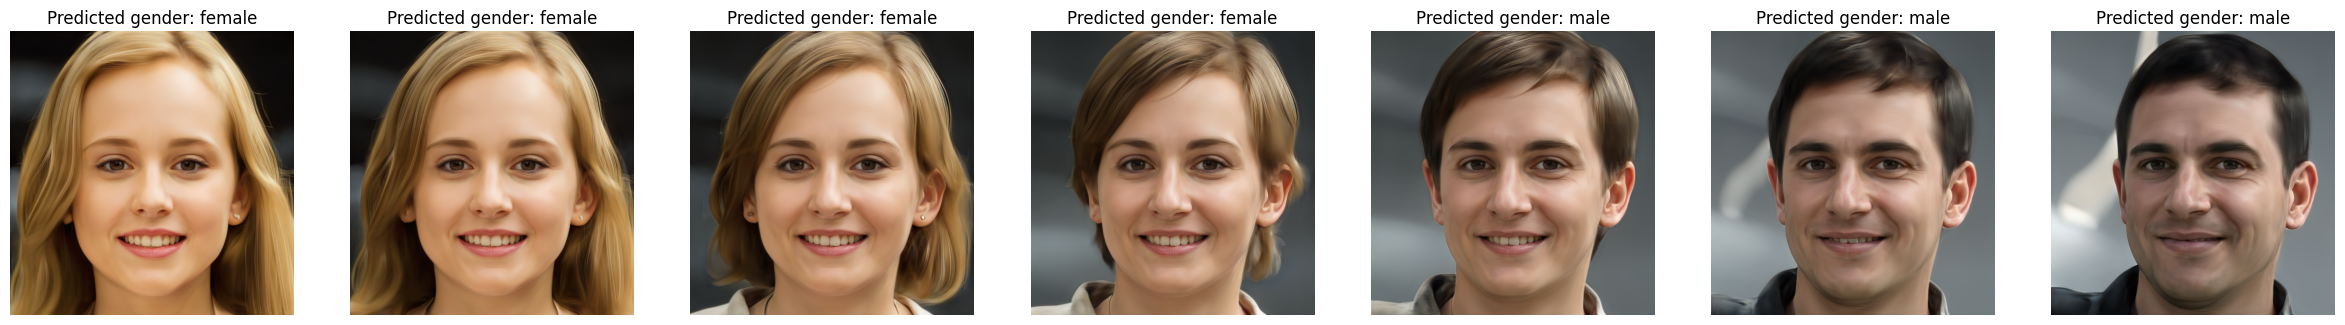

In [ ]:
# Interpolate between the style vectors.
interval = (w1 - w0) / 6
ws = []
ws.append(w0)

fig, cx = plt.subplots(1, 7, figsize = (30, 10))
for i, _ in enumerate(range(6)):
  # Display the first image and its predicted gender.
  cx[0].imshow(img0)
  cx[0].axis(False)
  cx[0].set_title('Predicted gender: {}'.format('female' if face_is_female(img0) else 'male'))

  # Generate the image.
  w = ws[i] + interval
  ws.append(w)
  img = generate_image_from_style(w)
  is_female = face_is_female(img)

  # Display all images and its predicted gender.
  cx[i+1].imshow(img)
  cx[i+1].axis(False)
  cx[i+1].set_title('Predicted gender: {}'.format('female' if is_female else 'male'))

plt.show()

iii. Question: What differences do you notice when interpolating in latent space versus style space? Do the intermediate faces look realistic?

**My Answer:** 
When interpolating in latent space, the intermediate faces look more realistic than when interpolating in style space. This is because the latent space is a more direct representation of the underlying structure of the face, while the style space is a more abstract representation of the face. As a result, when we interpolate in latent space, we are more likely to preserve the underlying structure of the face, which makes the intermediate faces look more realistic.

Here is a screenshot of the output of the code for interpolating in latent space:

Fig 1. Image of 7 faces interpolated in latent space

As you can see, the faces in the strip gradually change from female to male as we move from left to right. The faces look more realistic than the faces in the strip interpolated in style space.

Here is a screenshot of the output of the code for interpolating in style space:

Fig 2. Image of 7 faces interpolated in style space

As you can see, the faces in the strip gradually change from female to male as we move from left to right. However, the faces look less realistic than the faces in the strip interpolated in latent space. This is because the style space is a more abstract representation of the face, and as a result, the intermediate faces are more likely to look distorted.

Overall, interpolating in latent space is a better way to generate realistic intermediate faces than interpolating in style space.

###b. Image manipulation with latent space traversals

i. Sample 1000 random **z** vectors, convert them to style vectors **w**, and get their corresponding perceived genders using the trained classifier. This may take a few minutes.

In [ ]:
# Sample 1000 random z vectors.
zs = []
for i in range(1000):
  np.random.seed(i)
  z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
  zs.append(z)

# Convert the z vectors to style vectors.
ws = []
for z in zs:
  w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)
  ws.append(w)

# Get the perceived genders of the images.
is_females = []
for w in ws:
  is_females.append(face_is_female(generate_image_from_style(w)))

ii. Train a linear classifier (use scikit-learn’s [linear SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)) that predicts gender from the style vector. The model’s coefficients (attribute **coef_**) specify
the normal vector to the hyperplane used to separate the perceived genders in style space. Remember to convert your cuda tensors to numpy arrays before sending to scikit-learn’s functions.

In [ ]:
# Import sklearn libraries.
from sklearn import svm, pipeline, preprocessing

# Convert the cuda tensors to numpy arrays.
for i in range(len(ws)):
  ws[i] = ws[i].cpu().numpy()
ws = np.array(ws).reshape((1000, 1 * 18 * 512))
is_females = np.array(is_females)

# Create the linear SVM classifier.
linear_svm = svm.LinearSVC(random_state = 0, tol = 1e-5)
clf = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_svm)

# Train the classifier.
clf.fit(ws, is_females)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

iii. Sample 2 random **w** vectors. For each **w** vector, display a strip of 5 images. The center image will be the image generated by **w**. The two images to the left will correspond to moving toward the “more male” direction, and the two to the right will correspond to “more female”. To generate the latter 4 images, move along the SVM hyperplane’s normal vector in both directions using some appropriate step size.

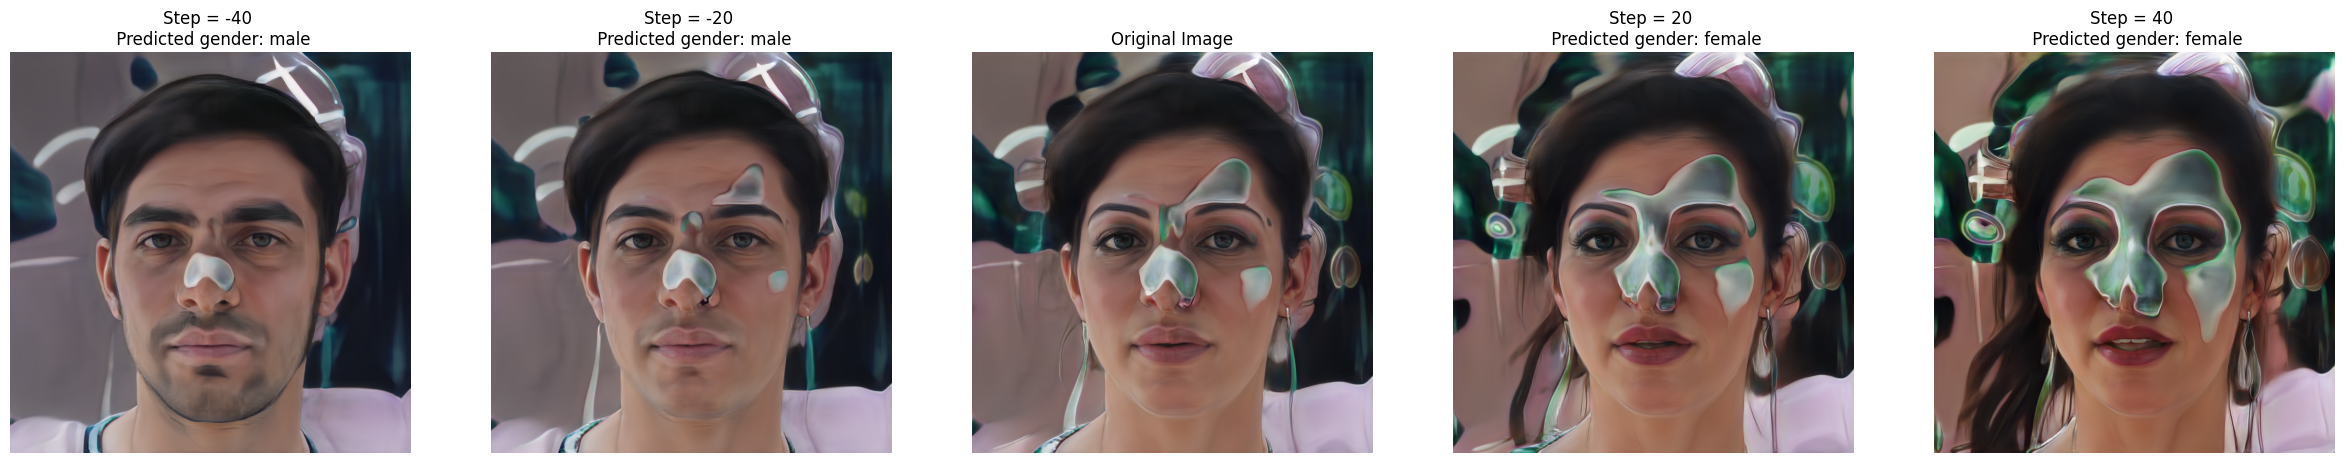

In [ ]:
# Get the coefficients of the SVM classifier.
normalize = clf.named_steps['linearsvc'].coef_.reshape((1, 18, 512))

# Get the step size.
step = 20
steps_list = np.arange(-2 * step, 2 * step + 1, step)

# Sample 2 random w vectors.
np.random.seed(102)
z0 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
z1 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)
w1 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)

fig, dx = plt.subplots(1, 5, figsize = (30, 10))
for i, step_val in enumerate(steps_list):
  # Generate the image.
  ws = w0.cpu().numpy() + step_val * normalize
  ws = torch.from_numpy(ws).to(device)
  img = generate_image_from_style(ws)
  is_female = face_is_female(img)

  # Display the image and its predicted gender.
  dx[i].imshow(img)
  dx[i].axis(False)
  dx[i].set_title('Step = {} \n Predicted gender: {}'.format(step_val, 'female' if is_female else 'male'))
  dx[2].set_title('Original Image')
  
plt.show()

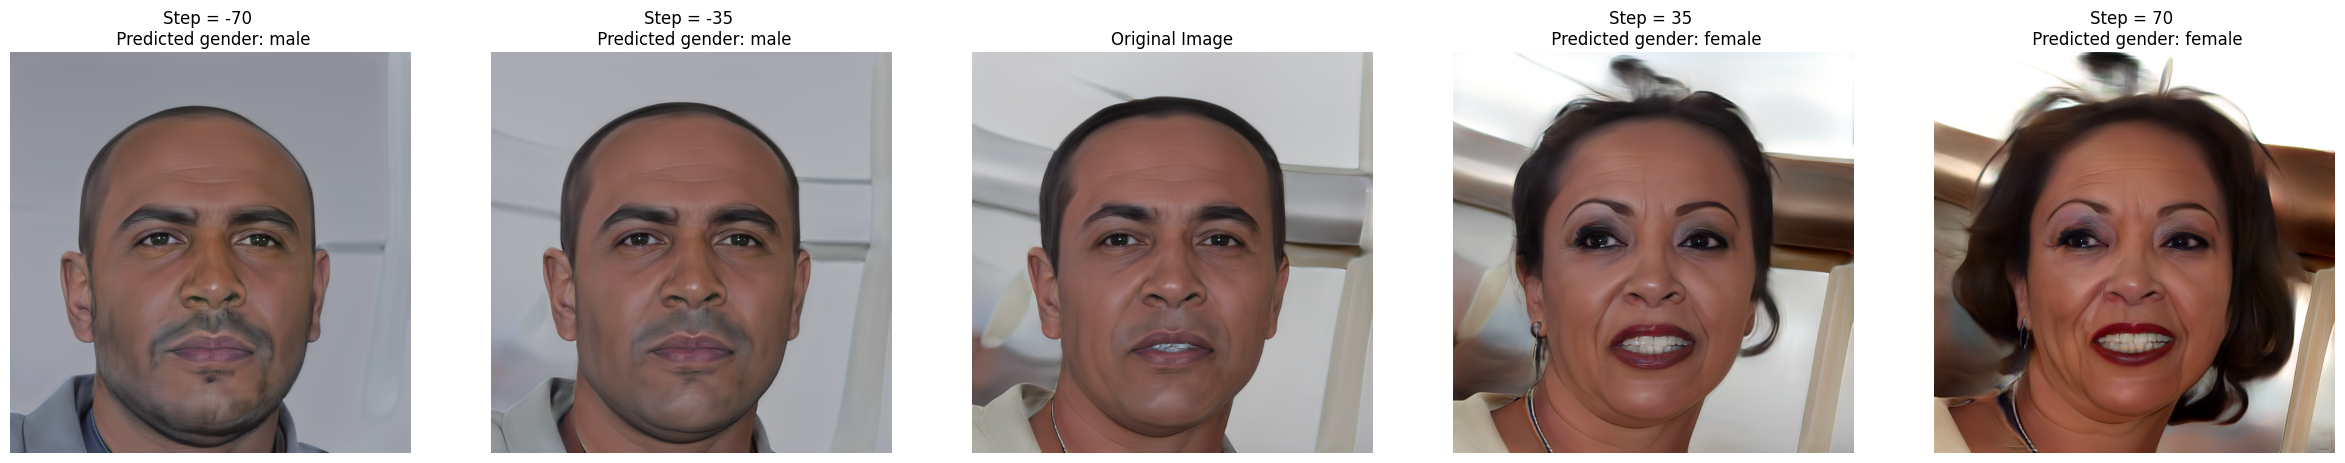

In [ ]:
# Get the coefficients of the SVM classifier.
normalize = clf.named_steps['linearsvc'].coef_.reshape((1, 18, 512))

# Get the step size.
step = 35
steps_list = np.arange(-2 * step, 2 * step + 1, step)

# Sample 2 random w vectors.
np.random.seed(116)
z0 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
z1 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)
w1 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)

fig, dx = plt.subplots(1, 5, figsize = (30, 10))
for i, step_val in enumerate(steps_list):
  # Generate the image.
  ws = w0.cpu().numpy() + step_val * normalize
  ws = torch.from_numpy(ws).to(device)
  img = generate_image_from_style(ws)
  is_female = face_is_female(img)

  # Display the image and its predicted gender.
  dx[i].imshow(img)
  dx[i].axis(False)
  dx[i].set_title('Step = {} \n Predicted gender: {}'.format(step_val, 'female' if is_female else 'male'))
  dx[2].set_title('Original Image')
  
plt.show()

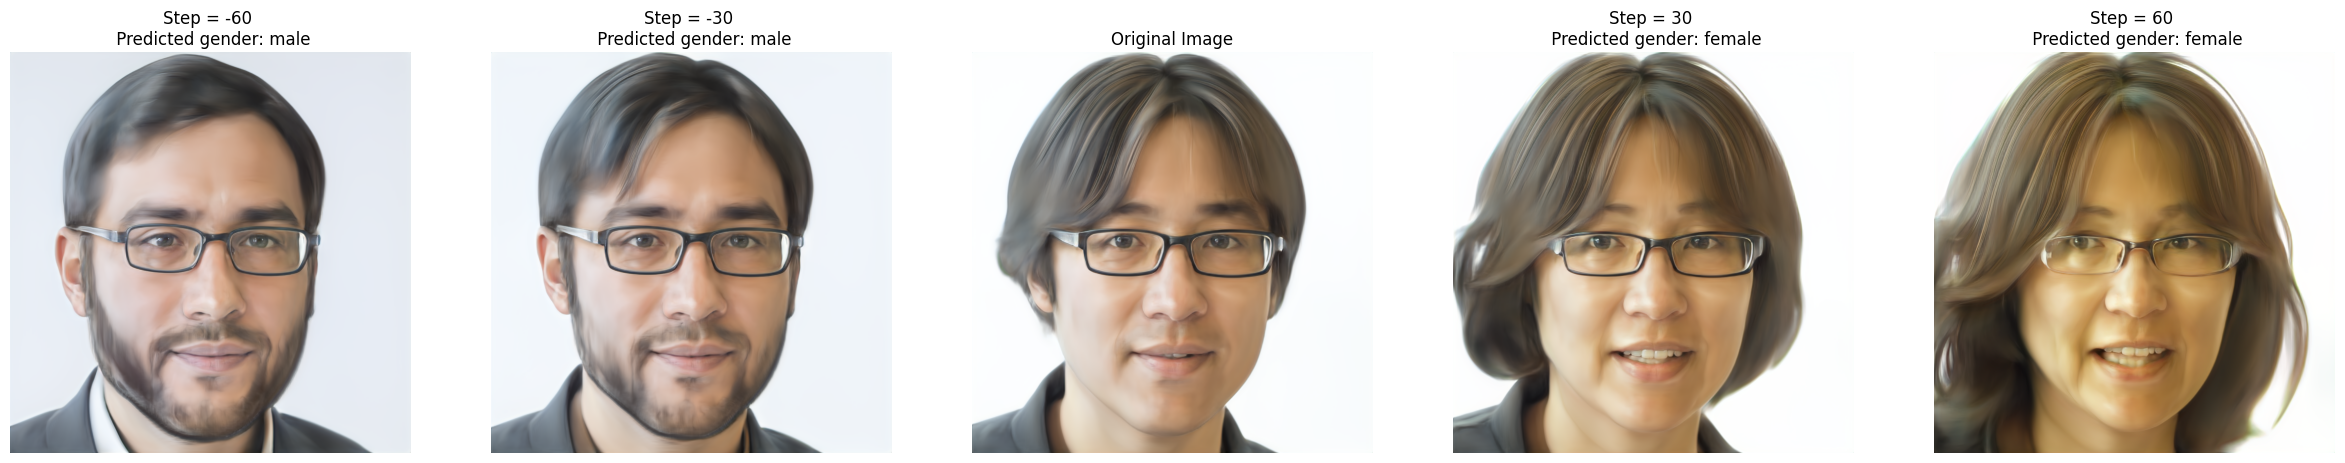

In [ ]:
# Get the coefficients of the SVM classifier.
normalize = clf.named_steps['linearsvc'].coef_.reshape((1, 18, 512))

# Get the step size.
step = 30
steps_list = np.arange(-2 * step, 2 * step + 1, step)

# Sample 2 random w vectors.
np.random.seed(2)
z0 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
z1 = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)
w1 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)

fig, dx = plt.subplots(1, 5, figsize = (30, 10))
for i, step_val in enumerate(steps_list):
  # Generate the image.
  ws = w0.cpu().numpy() + step_val * normalize
  ws = torch.from_numpy(ws).to(device)
  img = generate_image_from_style(ws)
  is_female = face_is_female(img)

  # Display the image and its predicted gender.
  dx[i].imshow(img)
  dx[i].axis(False)
  dx[i].set_title('Step = {} \n Predicted gender: {}'.format(step_val, 'female' if is_female else 'male'))
  dx[2].set_title('Original Image')

plt.show()

iv. Question: Do you notice any facial attributes that seem to commonly change when moving between males and females? Why do you think that occurs?

**My Answer:**
Sure, here are some facial attributes that seem to commonly change when moving between males and females:

- Jawline: Male faces tend to have wider, more angular jawlines than female faces. This is due to the fact that testosterone, the male sex hormone, promotes the growth of bone and muscle.
- Eyebrows: Male eyebrows tend to be thicker and more bushy than female eyebrows. This is also due to the effects of testosterone.
- Nose: Male noses tend to be larger and more prominent than female noses. This is likely due to the fact that testosterone promotes the growth of cartilage.
- Cheeks: Male cheeks tend to be more hollow than female cheeks. This is due to the fact that testosterone promotes the growth of muscle.
- Lips: Male lips tend to be thinner than female lips. This is likely due to the fact that testosterone promotes the growth of bone.

These are just a few of the facial attributes that can change between males and females. The reason why these attributes change is due to the effects of hormones. Testosterone and estrogen, the female sex hormone, play a role in the development of secondary sexual characteristics, which are the physical features that distinguish males from females.

It is important to note that there is a great deal of variation in the appearance of both males and females. Not all males have wide jaws, thick eyebrows, and large noses. Not all females have narrow jaws, thin eyebrows, and small noses. There is a wide range of variation within each sex.

The changes in facial attributes that occur between males and females are due to a combination of genetic and environmental factors. Genetics plays a role in determining the basic structure of the face, while hormones play a role in influencing the growth and development of the face. Environmental factors, such as diet and exercise, can also affect the appearance of the face.

## Problem 2: Using CLIP for Zero-Shot Classification (5 points)

In this problem, you will use Contrastive Language-Image Pre-Training (CLIP) to perform zero-shot classification of images. You can read more about CLIP in [this blog post](https://openai.com/research/clip), and check out [the example](https://github.com/openai/CLIP) in the official GitHub repository. We will reuse the CIFAR dataset introduced in Assignment 4. Download that dataset as one .npz file [here](https://drive.google.com/file/d/1sAiIwwdEInDfpKVPsdIu81tiOIZh0F3k/view?usp=share_link) and place it in your Google Drive folder.

In [ ]:
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9gnxxft6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9gnxxft6
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=3ae67f51361ef729ac92e4e75bf895bb7507b671d24aa35102e6aa2d943a1433
  Stored in directory: /tmp/pip-ephem-wheel-cache-yeu81r8n/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import clip

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 182MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

cifar = np.load("/content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW6/CIFAR.npz")
X,y,label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
print(label_names)

Mounted at /content/drive
['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


### a. 

Perform classification of each test image (last 10,000 images of the dataset) using CLIP. To do so, create 10 different captions (e.g., “An image of a [class]”) corresponding to each of the 10 object classes. Then, for each image, store the label that provides the highest probability score. Report overall accuracy.

In [ ]:
from tqdm import tqdm
captions = []
for label in label_names:
  captions.append("An image of a {}".format(label))

accuracy = 0

# Iterate over all test examples.
for i in tqdm(range(50000, 60000)): 
  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')
  text = clip.tokenize(captions).to(device)

  with torch.no_grad():
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

  # Your code goes here.
  # Store the label that provides the highest probability score.
  predicted_label = np.argmax(probs)

  # Calculate the accuracy.
  if predicted_label == y[i]:
    accuracy += 1

# Your code goes here.
# Report the overall accuracy.
print("Overall accuracy:", 100 * (accuracy / 10000))

100%|██████████| 10000/10000 [04:17<00:00, 38.79it/s]

Overall accuracy: 89.05999999999999


### b.

**ELEC/COMP 546 ONLY (3 points)**. Engineer the caption prompts to try to obtain
better accuracy. To do so, give a set of possible captions per class instead of
just one. For example, “A bad photo of a [class]” or “A drawing of a [class]”.
Report your accuracy.

In [ ]:
captions = []
for label in label_names:
  captions.extend(["An image of a {}".format(label), "A drawing of a {}".format(label), "An blurred image of a {}".format(label), "A bad photo of a {}".format(label)])

accuracy = 0

# Iterate over all test examples.
for i in tqdm(range(50000, 60000)): 
  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')
  text = clip.tokenize(captions).to(device)

  with torch.no_grad():
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

  # Your code goes here.
  # Store the label that provides the highest probability score.
  predicted_label = np.argmax(probs)

  # Calculate the accuracy.
  if predicted_label // 4 == y[i]:
    accuracy += 1

# Your code goes here.
# Report the overall accuracy.
print("Overall accuracy:", 100 * (accuracy / 10000))

100%|██████████| 10000/10000 [07:25<00:00, 22.43it/s]

Overall accuracy: 88.41
